In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, GlobalAveragePooling1D, Dense, Dropout 
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model

# Dataset Loading

In [2]:
authentic = pd.read_csv("../input/banfakenews/Authentic-48K.csv")
fake = pd.read_csv("../input/banfakenews/Fake-1K.csv")
label_authentic = pd.read_csv("../input/banfakenews/LabeledAuthentic-7K.csv")
label_fake = pd.read_csv("../input/banfakenews/LabeledFake-1K.csv")


# Initialization of dataset

In [3]:
print("Shape of authentic is :", authentic.shape)
authentic.head()

Shape of authentic is : (48678, 7)


,articleID,domain,date,category,headline,content,label
0,1,jagonews24.com,2018-09-19 17:48:18,Education,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজ",গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,1
1,2,jagonews24.com,2018-09-19 17:48:19,National,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারিশ,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,1
2,3,jagonews24.com,2018-09-19 17:48:20,National,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,1
3,4,jagonews24.com,2018-09-19 17:48:21,Crime,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,1
4,5,jagonews24.com,2018-09-19 17:48:21,National,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,1


In [4]:
authentic.label.value_counts()

1    48678
Name: label, dtype: int64

In [5]:
print("Shape of fake is :", fake.shape)
fake.head()

Shape of fake is : (1299, 7)


,articleID,domain,date,category,headline,content,label
0,1,channeldhaka.news,2019-03-14T13:34:14+00:00,International,মুরগির হামলায় শেয়াল নিহত,"বাংলায় একটা প্রবাদ আছে, শেয়ালের কাছে মুরগী বর্...",0
1,2,earki.com,"সেম্বর ১৭, ২০১৮",Miscellaneous,বিটিভিতে যেবার আমি ইন্টারভিউ দিতে গেলাম,"BTV থেকে লোকজন আসছে, ইন্টারভিউ নিবে।চারজনের টি...",0
2,3,earki.com,"২০:৩৯, জানুয়ারি ১৪, ২০১৯",Miscellaneous,বিদেশ থেকে উন্নতমানের বিরোধীদল আমদানি করার পরা...,অদ্ভুত বিরোধীদলহীনতায় ভুগছে সরকার। এ এক অন্যরক...,0
3,4,channeldhaka.news,2018-06-30T15:56:47+00:00,Sports,অবসর নেয়ার ঘোষণা দিলেন মেসি !,রাশিয়া বিশ্বকাপ নকআউট পর্বে ফ্রান্সের সাথে ৪-৩...,0
4,5,motikontho.wordpress.com,2013-03-05T21:55:45+00:00,Miscellaneous,"মাদারফাকার নহে, ব্রাদারফাকার: সাকা | দৈনিক মতি...","নিজস্ব মতিবেদক‘মাদারফাকার নহে, আমি ব্রাদারফাকা...",0


In [6]:
fake.label.value_counts()

0    1299
Name: label, dtype: int64

In [7]:
print("Shape of label_authentic is :",label_authentic.shape)
label_authentic.head()

Shape of label_authentic is : (7202, 9)


,articleID,domain,date,category,source,relation,headline,content,label
0,1,bd-pratidin.com,2018-09-20 08:16:43,Sports,আফগান ক্রিকেট বোর্ড (এসিবি) প্রধান,Related,হঠাৎ আফগান ক্রিকেট বোর্ড প্রধানের পদত্যাগ,ক্রিকেট বিশ্বের নতুন চমকের নাম আফগানিস্তান। কয়...,1.0
1,2,jugantor.com,2018-09-20 20:20:20,Sports,Reporter,Related,টস হেরে বোলিংয়ে বাংলাদেশ,এশিয়া কাপের ষষ্ঠ ম্যাচে বাংলাদেশ দলের বিপক্ষে ...,1.0
2,3,bd24live.com,2018-09-20 16:39:40,National,Reporter,Related,রাজধানীতে বিশেষ অভিযানে আটক ৪৩,রাজধানীতে মাদক বিরোধী বিশেষ অভিযান পরিচালনা কর...,1.0
3,4,bd24live.com,2018-09-19 18:27:56,National,জননিরাপত্তা বিভাগের সচিব,Related,উস্কানি রোধে নজরদারি থাকবে সামাজিক যোগাযোগ মাধ...,সনাতন ধর্মাবলম্বীদের সবচেয়ে বড় ধর্মীয় উৎসব দুর...,1.0
4,5,somoynews.tv,2018-09-20 10:15:28,Finance,পেট্রোল পাম্প মালিক সমিতি সভাপতি,Related,"'যেখানে তেল আসত ৭ দিনে, এখন তা আসবে অতি দ্রুত'",ভারত থেকে পাইপ লাইনের মাধ্যমে সরাসরি দেশে জ্বা...,1.0


In [8]:
label_authentic.label.value_counts()

1.0    7202
Name: label, dtype: int64

In [9]:
print("Shape of label_fake is :",label_fake.shape)
label_fake.head()

Shape of label_fake is : (1299, 10)


,articleID,domain,date,category,source,relation,headline,content,label,F-type
0,1,channeldhaka.news,2019-03-14T13:34:14+00:00,International,Reporter,Unrelated,মুরগির হামলায় শেয়াল নিহত,"বাংলায় একটা প্রবাদ আছে, শেয়ালের কাছে মুরগী বর্...",0,Satire
1,2,earki.com,"সেম্বর ১৭, ২০১৮",Miscellaneous,Reporter,Unrelated,বিটিভিতে যেবার আমি ইন্টারভিউ দিতে গেলাম,"BTV থেকে লোকজন আসছে, ইন্টারভিউ নিবে।চারজনের টি...",0,Satire
2,3,earki.com,"২০:৩৯, জানুয়ারি ১৪, ২০১৯",Miscellaneous,Reporter,Unrelated,বিদেশ থেকে উন্নতমানের বিরোধীদল আমদানি করার পরা...,অদ্ভুত বিরোধীদলহীনতায় ভুগছে সরকার। এ এক অন্যরক...,0,Satire
3,4,channeldhaka.news,2018-06-30T15:56:47+00:00,Sports,Reporter,Unrelated,অবসর নেয়ার ঘোষণা দিলেন মেসি !,রাশিয়া বিশ্বকাপ নকআউট পর্বে ফ্রান্সের সাথে ৪-৩...,0,Satire
4,5,motikontho.wordpress.com,2013-03-05T21:55:45+00:00,Miscellaneous,Reporter,Unrelated,"মাদারফাকার নহে, ব্রাদারফাকার: সাকা | দৈনিক মতি...","নিজস্ব মতিবেদক‘মাদারফাকার নহে, আমি ব্রাদারফাকা...",0,Satire


In [10]:
label_fake.label.value_counts()

0    1299
Name: label, dtype: int64

# Data Preprocessing

In [11]:
authentic = authentic.loc[:, ['content', 'label']]
fake = fake.loc[:, ['content', 'label']]

train = pd.concat([authentic, fake], axis=0, ignore_index=True)

label_authentic = label_authentic.loc[:, ['content', 'label']]
label_fake = label_fake.loc[:, ['content', 'label']]

test = pd.concat([label_authentic, label_fake], axis=0, ignore_index=True)
test['label'] = test.label.astype(int)

In [12]:
print("Shape of train is {}".format(train.shape))
print("Shape of test is {}".format(test.shape))

Shape of train is (49977, 2)
Shape of test is (8501, 2)


# Balance, Imbalance check of train and test

<AxesSubplot:>

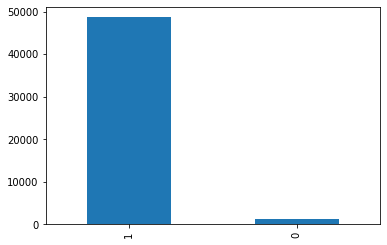

In [13]:
train['label'].value_counts().plot(kind='bar')

<AxesSubplot:>

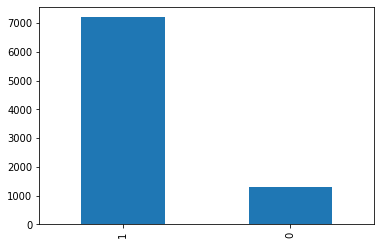

In [14]:
test.label.value_counts().plot(kind='bar')

# Word Counting

In [15]:
# Average word in train and test content
train_word_average = np.mean(train['content'].apply(lambda x: len(x.split())))
test_word_average = np.mean(test['content'].apply(lambda x: len(x.split())))
print("Average word in train is {} Average word in test is {}".format(train_word_average, test_word_average))

# Minimum word in train and test content 
train_word_minimum = np.min(train['content'].apply(lambda x: len(x.split())))
test_word_minimum = np.min(test['content'].apply(lambda x: len(x.split())))
print("Minimum word in train is {} Minimum word in test is {}".format(train_word_minimum, test_word_minimum))


# Maximum word in train and test content
train_word_maximum = np.max(train['content'].apply(lambda x: len(x.split())))
test_word_maximum = np.max(test['content'].apply(lambda x: len(x.split())))
print("Maximum word in train is {} Maximum word in test is {}".format(train_word_maximum, test_word_maximum))


Average word in train is 277.2645216799728 Average word in test is 261.41218680155276
Minimum word in train is 0 Minimum word in test is 7
Maximum word in train is 4788 Maximum word in test is 3761


# Dataset Cleaning

In [16]:
# Taking those rows where have > 100 words 
train = train[train['content'].apply(lambda x: len(x.split()) > 100 )].reset_index(drop=True) 
test = test[test['content'].apply(lambda x:  len(x.split()) > 100 )].reset_index(drop=True) 
print("Shape of train is {} shape of test is {}".format(train.shape, test.shape))

Shape of train is (45006, 2) shape of test is (7520, 2)


In [17]:
# Loading bengali stop words file
with open('../input/begali-stopword/stopwords-bn.txt', 'r', encoding='utf-8-sig') as f:
    stop_word = f.read()
    stop_word = stop_word.replace(" ", "")
    stop_word = stop_word.split('\n')
    print(stop_word)

['অতএব', 'অথচ', 'অথবা', 'অনুযায়ী', 'অনেক', 'অনেকে', 'অনেকেই', 'অন্তত', 'অন্য', 'অবধি', 'অবশ্য', 'অর্থাত', 'আই', 'আগামী', 'আগে', 'আগেই', 'আছে', 'আজ', 'আদ্যভাগে', 'আপনার', 'আপনি', 'আবার', 'আমরা', 'আমাকে', 'আমাদের', 'আমার', 'আমি', 'আর', 'আরও', 'ই', 'ইত্যাদি', 'ইহা', 'উচিত', 'উত্তর', 'উনি', 'উপর', 'উপরে', 'এ', 'এঁদের', 'এঁরা', 'এই', 'একই', 'একটি', 'একবার', 'একে', 'এক্', 'এখন', 'এখনও', 'এখানে', 'এখানেই', 'এটা', 'এটাই', 'এটি', 'এত', 'এতটাই', 'এতে', 'এদের', 'এব', 'এবং', 'এবার', 'এমন', 'এমনকী', 'এমনি', 'এর', 'এরা', 'এল', 'এস', 'এসে', 'ঐ', 'ও', 'ওঁদের', 'ওঁর', 'ওঁরা', 'ওই', 'ওকে', 'ওখানে', 'ওদের', 'ওর', 'ওরা', 'কখনও', 'কত', 'কবে', 'কমনে', 'কয়েক', 'কয়েকটি', 'করছে', 'করছেন', 'করতে', 'করবে', 'করবেন', 'করলে', 'করলেন', 'করা', 'করাই', 'করায়', 'করার', 'করি', 'করিতে', 'করিয়া', 'করিয়ে', 'করে', 'করেই', 'করেছিলেন', 'করেছে', 'করেছেন', 'করেন', 'কাউকে', 'কাছ', 'কাছে', 'কাজ', 'কাজে', 'কারও', 'কারণ', 'কি', 'কিংবা', 'কিছু', 'কিছুই', 'কিন্তু', 'কী', 'কে', 'কেউ', 'কেউই', 'কেখা', 'কেন', 'কোটি', 'কোন', 'কোনও'

In [18]:
def clean_text(text):
    row = str(text)
    row = row.replace('\n', ' ')
    row = row.replace('\t', ' ')
    row = row.replace('\\', "")
    row = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', row)
    row = re.sub(' +', ' ', row)
    row = row.replace("।", "")
    row = re.sub('[১২৩৪৫৬৭৮৯০]', '', row)
    row = re.sub('[1234567890]', '', row) 
    row = row.replace('’', '')
    row = row.replace('‘', '')
    
    # remove stopwords
    # Removing stop words
    row = row.split()
    row = [w for w in row if not w in stop_word]
    row = " ".join(row)
    return row

In [19]:
train['content'] = train['content'].apply(lambda x: clean_text(x))
test['content'] = test['content'].apply(lambda x: clean_text(x))
print("Shape of train is {} shape of test is {}".format(train.shape, test.shape))

Shape of train is (45006, 2) shape of test is (7520, 2)


# Visualizing some text and label

In [20]:
for i in range(5):
    print(train['label'][i])
    print(train['content'][i])

1
গত সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে বাকৃবি উপাচার্যের কার্যালয়ে হট্টগোলের ঘটনায় দুইজনকে সাময়িক বরখাস্ত ছয় শোকজ বিশ্ববিদ্যালয় প্রশাসন বুধবার বিশ্ববিদ্যালয় বাকৃবি রেজিস্ট্রার সাইফুল ইসলাম স্বাক্ষরিত এক নোটিশে দিনের উপযুক্ত দেয়ার নির্দেশ দেয়া হয়েছে এদিকে ঘটনায় আন্দোলনের একাত্বতা প্রকাশ করায় হামলার শিকার হয়ে কারিগরি কর্মচারী পরিষদের সভাপতি সম্পাদক হাসপাতালে ভর্তি হয়েছেন সাময়িক বরখাস্তরা হলেন শিক্ষা বিষয়ক শাখার কর্মচারী য় শ্রেণির সম্পাদক মো মোশারফ হোসেন কর্মকর্তা পরিষদের যুগ্ম সম্পাদক জিয়াউর রহমান টিটু এছাড়া বিশ্ববিদ্যালয় সম্প্রসারণ কেন্দ্রের সহকারী পরিচালক মোহাম্মদ আবুল বাসার আমজাদ ডেপুটি লাইব্রেরিয়ান মোখাইরুল আলম নান্নু মোআবদুল বাতেন ক্রীড়া প্রশিক্ষণ বিভাগের মোহাম্মদ মোস্তাইন কবীর সোহেল সংস্থাপন শাখার সহকারী রেজিস্ট্রার মোহাম্মদ আশিকুল আলম বাচ্চু খামার ব্যবস্থাপনা শাখার অ্যাডিশনাল রেজিস্ট্রার ড মো হেলাল উদ্দীনকে দর্শানোর নোটিশ দেয় প্রশাসন নোটিশে উল্লেখ গত সোমবার দুপুরে সোয়া টার উপাচার্যের অনুমতি ছাড়াই হঠাৎ উপাচার্যের কার্যালয়ে প্রবেশ ছাত্র বিষয়ক উপদেষ্টা প্রক্টর ডিন কাউন্সিলের আহ

In [21]:
for i in range(5):
    print(test['label'][i])
    print(test['content'][i])

1
ক্রিকেট বিশ্বের চমকের নাম আফগানিস্তান বছরে পারফরম্যান্স নজর কেড়েছে ক্রিকেট জগতের এশিয়া কাপের তম আসরেও দারুণ ছন্দে আফগান ক্রিকেটাররা পাঁচবারের এশিয়া কাপ চ্যাম্পিয়ন শ্রীলঙ্কাকে হারিয়ে এরই সেরা চারে পৌঁছে দলের ভালো সময়ে হঠাৎ পদত্যাগ আফগান ক্রিকেট বোর্ড এসিবি প্রধান আতিফ মাশাল হঠাৎ কারণে পদত্যাগ ওঠা প্রশ্নের জবাব দিয়েছেন আতিফ জানান সরকারের পদে নিয়োগ দেওয়ার কারণেই বোর্ডের দায়িত্ব অব্যাহতি পরিবর্তে এসিবির দায়িত্ব নেবেন আফগান বোর্ডের সাবেক সভাপতি আজিজ উল্লাহ ফজলে সালের জানুয়ারিতে পাঁচ বছরের আতিফকে বোর্ড প্রধান নির্বাচন দায়িত্বের আড়াই বছরের মাথায় দায়িত্ব অব্যাহতি বিডি প্রতিদিন ওয়াসিফ
1
এশিয়া কাপের ষষ্ঠ ম্যাচে বাংলাদেশ দলের বিপক্ষে টস জিতে প্রথমে ব্যাট সিদ্ধান্ত নিয়েছেন আফগানিস্তান ক্রিকেট দলের অধিনায়ক আসগর আফগান আবুধাবিতে খেলাটি অনুষ্ঠিত দেড় যুগ বাংলাদেশ টেস্ট আঙিনায় পা রাখে আফগানদের ক্রিকেটে হাতেখড়িই হয়নি বছর আন্তর্জাতিক ক্রিকেটে ফরম্যাট মিলিয়ে মুখোমুখি লড়াইয়ে আফগানিস্তানের চেয়ে পিছিয়ে থাকাটা বাংলাদেশের নিঃসন্দেহে বিব্রতকর ব্যাপার আবুধাবিতে এশিয়া কাপের গ্রুপ পর্বের শেষ ম্যাচে খেলছে দুদল নি

In [22]:
train_word_average = np.mean(train['content'].apply(lambda x: len(x.split())))
test_word_average = np.mean(test['content'].apply(lambda x: len(x.split())))
print("Average word in train is {} Average word in test is {}".format(train_word_average, test_word_average))


Average word in train is 215.18202017508776 Average word in test is 205.25890957446808


In [23]:
train['label'].value_counts()

1    43811
0     1195
Name: label, dtype: int64

In [24]:
test['label'].value_counts()

1    6325
0    1195
Name: label, dtype: int64

# Splitting dataset

In [25]:
X = train['content'].values
y = train['label'].values

test_x = test['content'].values
test_y = test['label'].values 

In [26]:
train_x, valid_x, train_y, valid_y = train_test_split(X, y, 
                                                      random_state=42, 
                                                      stratify=y)

# Tokenization and Pad Sequence

In [27]:
embed_size = 300
max_features = 120000
max_len = 250

In [28]:
full_text = list(train_x) + list(valid_x) + list(test_x) 

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(full_text) 

In [ ]:
# Tokenizer for KFold
# full_text = list(X) + list(test_x) 
# tokenizer = Tokenizer(num_words=max_features) 
# tokenizer.fit_on_texts(full_text) 

In [29]:
# Tokenizing
train_x = tokenizer.texts_to_sequences(train_x)
valid_x = tokenizer.texts_to_sequences(valid_x)
test_x = tokenizer.texts_to_sequences(test_x) 

# Pad sequences 
train_x = pad_sequences(train_x, maxlen=max_len, padding='post')
valid_x = pad_sequences(valid_x, maxlen=max_len, padding='post')
test_x = pad_sequences(test_x, maxlen=max_len, padding='post')  

In [ ]:
# Tokenizing and pad sequence for KFold

# X = tokenizer.texts_to_sequences(X)
# X = pad_sequences(X, maxlen=max_len, padding='post') 

# Model

In [30]:
# Building Model
input = Input(shape=(max_len,))
x = Embedding(max_features, embed_size)(input)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalAveragePooling1D()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input, outputs=x)

In [31]:
# Model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 300)          36000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 128)          140544    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17    

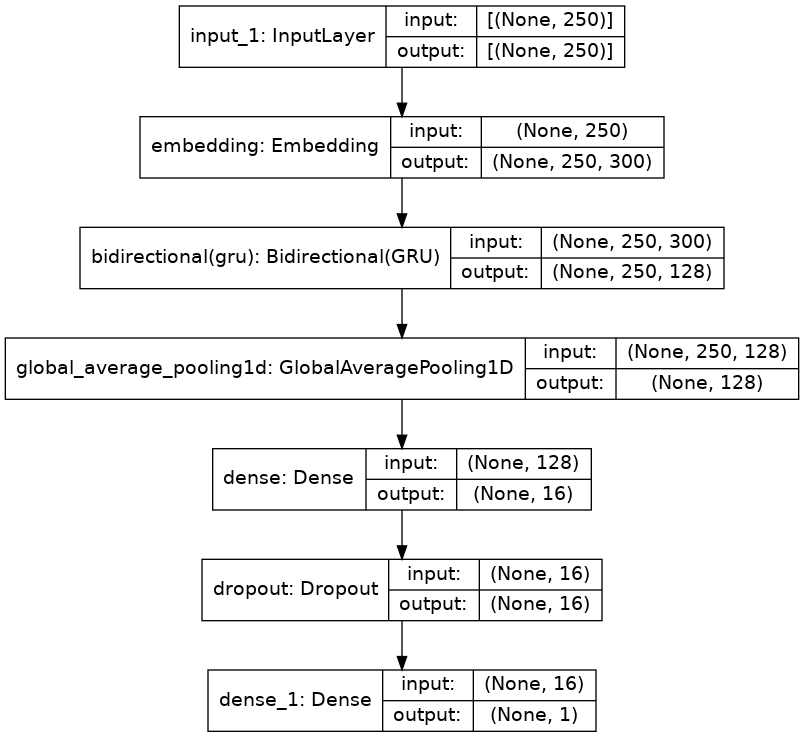

In [32]:
#plotting model
plot_model(model, show_shapes=True, to_file = 'Bengali_Sentiment_model.png')

In [33]:
# Compile Model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Model Train

In [34]:
checkpoints = ModelCheckpoint('weight.hdf5', 
                               monitor='val_loss', 
                               mode='max', 
                               verbose=True, 
                               save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=2, 
                              verbose=1, 
                              min_lr=0.000001)


early_stop = EarlyStopping(monitor='val_loss', patience=3)


In [ ]:
# Training with KFold 
# skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=10)

# for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
#     train_x = X[train_idx]
#     train_y = y[train_idx]
#     valid_x = X[valid_idx]
#     valid_y = y[valid_idx] 
    
#     model.fit(train_x, train_y,
#               batch_size=512,
#               epochs=20,
#               validation_data=(valid_x, valid_y),
#               callbacks=[checkpoints, reduce_lr])

In [35]:
# without KFold 
history = model.fit(train_x, train_y, 
          batch_size=512, 
          epochs=20, 
          validation_data=(valid_x, valid_y), 
          callbacks=[checkpoints, reduce_lr, early_stop]) 

Epoch 1/20
66/66 [==============================] - 53s 720ms/step - loss: 0.3744 - accuracy: 0.9160 - val_loss: 0.1006 - val_accuracy: 0.9734

Epoch 00001: val_loss improved from -inf to 0.10064, saving model to weight.hdf5
Epoch 2/20
66/66 [==============================] - 46s 696ms/step - loss: 0.0922 - accuracy: 0.9741 - val_loss: 0.0511 - val_accuracy: 0.9834

Epoch 00002: val_loss did not improve from 0.10064
Epoch 3/20
66/66 [==============================] - 46s 697ms/step - loss: 0.0286 - accuracy: 0.9918 - val_loss: 0.0362 - val_accuracy: 0.9915

Epoch 00003: val_loss did not improve from 0.10064
Epoch 4/20
66/66 [==============================] - 45s 689ms/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.0468 - val_accuracy: 0.9915

Epoch 00004: val_loss did not improve from 0.10064
Epoch 5/20
66/66 [==============================] - 45s 689ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0716 - val_accuracy: 0.9911

Epoch 00005: val_loss did not improve from 0.1

# Model Evaluation

In [36]:
print("Loss of the model is {}".format(model.evaluate(valid_x, valid_y)[0]) )
print("Accuracy of the model is {}%".format(model.evaluate(valid_x, valid_y)[1]*100 ))

352/352 [==============================] - 4s 11ms/step - loss: 0.0652 - accuracy: 0.9916
Loss of the model is 0.06520484387874603
352/352 [==============================] - 4s 13ms/step - loss: 0.0652 - accuracy: 0.9916
Accuracy of the model is 99.15570616722107%


# Accuracy and Loss of train and valid

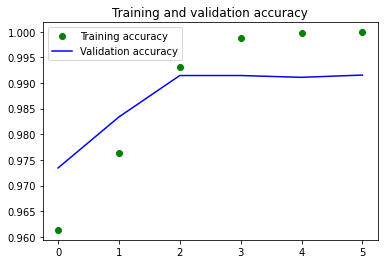

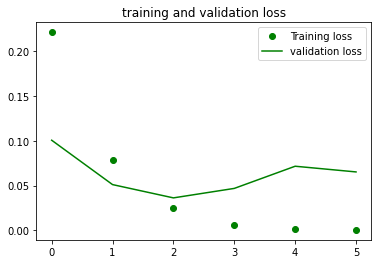

In [37]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(val_accuracy))
plt.plot(epochs, accuracy, 'go', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

# Model Saving and Loading

In [38]:
# Manually saving full model with hdf5 format 
model.save('fake_news_classification.h5') 

# Loading full model 
model_loaded = load_model('fake_news_classification.h5') 

# Predicting with test data

In [39]:
y_pred = model.predict(test_x)
y_pred

array([[9.9997699e-01],
       [9.9999595e-01],
       [9.9998105e-01],
       ...,
       [7.1924669e-04],
       [9.9970275e-01],
       [1.2973438e-03]], dtype=float32)

In [40]:
y_pred = np.rint(y_pred)
y_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

# Classification Report and Confusion Matrix

In [41]:
# classification report
print(classification_report(y_pred, test_y))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97      1117
         1.0       1.00      0.99      0.99      6403

    accuracy                           0.99      7520
   macro avg       0.97      0.99      0.98      7520
weighted avg       0.99      0.99      0.99      7520



<AxesSubplot:>

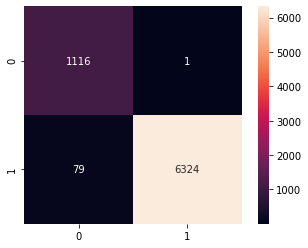

In [42]:
# Confusion matrix
con_mat = confusion_matrix(y_pred, test_y)
sns.heatmap(con_mat, square=True, annot=True, fmt='d') 

# Predicting with totally new data

In [43]:
def text_predict(text, max_len):
    #text cleaning
    text_cleaned = clean_text(text)
    
    #tokenizing
    text_token = tokenizer.texts_to_sequences([text_cleaned])
    text_pad = pad_sequences(text_token, padding='post', maxlen=max_len)
    
    pred = model.predict(text_pad)
    print(np.rint(pred))
    

In [44]:
# New text 
text = "Despite taking aggressive measures to import rice in the last three months, the government has so far failed to replenish the country's depleting grain stocks.The current stock of food grain is at its lowest in the last few years. Both the cabinet committee on economic affairs and purchase approved a number of proposals in the past three months to import a total of 15.5 lakh tonnes of rice under government-to-government (G-to-G) arrangement and through international tenders. The latest move to import rice came yesterday, when the two cabinet committees approved two proposals to import 1.5 lakh tonnes of rice from India. During yesterday's cabinet meetings, chaired by Finance Minister AHM Mustafa Kamal, the cabinet committee on economic affairs approved the food department's proposal to import one lakh tonnes of rice from Indian state-owned National Federation of Farmer's Procurement, Processing and Retailing Cooperatives India (NACOF)."

# Calling the function
text_predict(text, max_len)

[[1.]]
